In [37]:
import os
import configparser

# Loading configurations
configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)

insert_amd_env_vars =  int(configParser.get('COMMON', 'insert_amd_env_vars'))
HSA_OVERRIDE_GFX_VERSION =  configParser.get('COMMON', 'HSA_OVERRIDE_GFX_VERSION')
ROCM_PATH =  configParser.get('COMMON', 'ROCM_PATH')

if(insert_amd_env_vars != 0):
    os.environ["HSA_OVERRIDE_GFX_VERSION"] = HSA_OVERRIDE_GFX_VERSION
    os.environ["ROCM_PATH"] = ROCM_PATH


import subprocess
import os
import pathlib
import configparser
import sqlite3 as sl
import cv2
from pydub import AudioSegment
import math
import pickle
import shutil
import time
import multiprocessing
from multiprocessing import Process,Queue
import itertools
from threading import Thread
import soundfile as sf
from deepface import DeepFace
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


start_time = time.time()    # To measure execution time in seconds


print("PLEASE EDIT configuration.txt BEFORE EXECUTION")
print(".wav files might be generated in path. The program will automatically delete them. If execuetion stops unexpectedly, please delete them yourself")



datasetPathVideo =  configParser.get('COMMON', 'datasetPathVideo')
datasetPathAudio =  configParser.get('extractAudio', 'datasetPathAudio')
p =  configParser.get('extractAudio', 'dbChunk')
ttwbdf =  int(configParser.get('extractAudio', 'time_to_wait_before_deleting_files'))
cuda =  int(configParser.get('COMMON', 'cuda'))
cpus =  int(configParser.get('COMMON', 'cpus'))
datasetPathDatabase =  configParser.get('COMMON', 'datasetPathDatabase') + '/dataset.db'
model_weights_path =  configParser.get('train_s2fe', 'model_weights_path')

# TODO dataset.db in configuration too

print("Video dataset at " + datasetPathVideo )
print("Number of cpus to use for multiprocessing : ", cpus)


  # Connection to databases
con = sl.connect(datasetPathDatabase,check_same_thread=False)
print('------------------- ABOUT TO START --------------------')

REQUIRED_SAMPLE_RATE = 16000
FACE_EMBEDDING_SIZE = 2622
AUDIO_MAX_LEN = 246000
len_to_input = int(configParser.get('train_s2fe', 'len_to_input'))
NO_OF_VIDEOS = int(configParser.get('train_s2fe', 'no_of_videos'))
validation_split = float(configParser.get('train_s2fe', 'validation_split')) 
BATCH_SIZE = int(configParser.get('train_s2fe', 'batch_size'))
save_freq = int(configParser.get('train_s2fe', 'save_freq'))
no_of_epochs = int(configParser.get('train_s2fe', 'no_of_epochs'))


def read_audio_file(file_path):
  with open(file_path, "rb") as f:
      audio_wave, sample_rate = sf.read(f)
  if sample_rate != REQUIRED_SAMPLE_RATE:
      raise ValueError(
          f"sample rate (={sample_rate}) of your files must be {REQUIRED_SAMPLE_RATE}"
      )
  return audio_wave

 
def extractAudio(row):
    absPathVideo = row[0][1]   # for this one video

    absPathAudio = y = absPathVideo.replace(datasetPathVideo,datasetPathAudio)  # for this one audio
    absPathAudio = os.path.splitext(absPathAudio)[0]
    absPathAudio_w = absPathAudio   # without the end
    absPathAudio = absPathAudio + "_audio.wav"  # full path to extracted audio from the video

    #Create Directory
    pathlib.Path(os.path.dirname(absPathAudio)).mkdir(parents=True, exist_ok=True) 

    # Extract audio monochannel and with 16khz and put it in absPathAudio
    command = "ffmpeg -nostats -loglevel 0 -y -i '" + absPathVideo + "' -acodec pcm_s16le -ab 160k -ac 1 -ar 16000 -vn '" + absPathAudio + "'"
    subprocess.call(command, shell=True)


    # Get original duration of video
    audio = AudioSegment.from_file(absPathVideo)
    audio_length_og = math.floor(audio.duration_seconds)
    #print(audio_length_og)
    


    # Will either truncate or loop the original video to reach audio_length (3,6,12 or 24)
    audio_length_list = [6,12,24]
    for audio_length in audio_length_list:
        path_var_len_audio =  absPathAudio_w + "audio" + str(audio_length) + "s.wav"    # path to the variable length audio
        path_var_len_audio_temp =  absPathAudio_w + "audio_temp" + str(audio_length) + "s.wav"  # path to a temp version of the variable length audio

        if(audio_length_og > audio_length):
            # Truncate    

            command = "ffmpeg -nostats -loglevel 0 -y -ss 0 -t "+str(audio_length)+" -i \"" + absPathAudio + "\" \"" + path_var_len_audio + "\""
            subprocess.call(command, shell=True)


        else:
            # Loop then truncaate
            #print("lesa")
            twoDigitLenStr = f"{audio_length:02}"
            #print(twoDigitLenStr)
            command = "ffmpeg -nostats -loglevel 0 -y -stream_loop -1 -i '" + absPathAudio + "' -t \"00:00:"+twoDigitLenStr+".000\" -codec:a \"aac\" -f \"wav\" -c copy '"+ path_var_len_audio_temp + "'"
            subprocess.call(command, shell=True)
            command = "ffmpeg -nostats -loglevel 0 -y -ss 0 -t "+str(audio_length)+" -i \"" + path_var_len_audio_temp + "\" \"" + path_var_len_audio + "\""
            subprocess.call(command, shell=True)



            # Will delete those files after a little bit
        ftd = [absPathAudio,path_var_len_audio,os.path.basename(path_var_len_audio),path_var_len_audio_temp]
        audio_wave = read_audio_file(path_var_len_audio)
        
        tDelete = Thread(target=delFiles, args=(ftd,))   # spawn a process
        tDelete.start()
    return audio_wave
        
           




            
# Function to delete audio temp files
def delFiles(filesToDelete):
    time.sleep(ttwbdf)  # wait a bit
    for file in filesToDelete:  
        try:
            os.remove(file)
        except OSError:
            pass
        


from random import randint
from scipy.fft import fft, ifft

def get_video(offset):
    
    try:
        #print('offset:' + str(offset))
        #print('offset:' + str(offset))
        data = con.execute("""SELECT V.ID, V.VIDEO_PATH, F.FACE_PATH FROM VIDEO V 
                        INNER JOIN FACE F ON F.ID = V.ID
                        LIMIT 1 OFFSET """ + str(offset))


        
        #print(data.fetchall())
        dataGotten = data.fetchall()
        if (len(dataGotten)) == 0:
            raise ValueError('No video was fetched')

        #print(dataGotten[0][0])
        #audio_wave = extractAudio(dataGotten)
        #audio_wave = audio_wave[0:len_to_input]
        #audio_wave = tf.constant(audio_wave, dtype=tf.float64)

        #audio = tf.squeeze(audio_wave, axis=-1)
        #fft = tf.signal.fft(
        #    tf.cast(tf.complex(real=audio_wave, imag=tf.zeros_like(audio_wave)), tf.complex64)
        #)
        #fft = tf.expand_dims(fft, axis=-1)
        #fft = tf.squeeze(fft, axis=1)
        #print()
        #fft = fft[0:(audio_wave.shape[0] // 2)]
        #fft = tf.math.abs(fft)
        #fft = tf.expand_dims(fft, axis=-1)

        embedding_objs = DeepFace.represent(dataGotten[0][2],enforce_detection=False)
        return embedding_objs[0]['embedding']
    except Exception as e:
        print('Error getting video, retrying ...:' + str(offset))
        return get_video(randint(1, NO_OF_VIDEOS - 1))


    








PLEASE EDIT configuration.txt BEFORE EXECUTION
.wav files might be generated in path. The program will automatically delete them. If execuetion stops unexpectedly, please delete them yourself
Video dataset at /media/gamal/Passport/Datasets/VoxCeleb2/Voxceleb2Video
Number of cpus to use for multiprocessing :  8
------------------- ABOUT TO START --------------------


In [38]:
import numpy as np
#np.set_printoptions(threshold=1000000)
get_video(1)

[0.022208206355571747,
 0.00870833732187748,
 0.009705554693937302,
 0.022133108228445053,
 -0.00856832042336464,
 0.02805948629975319,
 0.0168148223310709,
 0.025296226143836975,
 0.015417026355862617,
 -0.00024067377671599388,
 0.027904100716114044,
 0.02999740093946457,
 0.03846729174256325,
 0.020235462114214897,
 0.013113459572196007,
 0.01708342507481575,
 0.01273964624851942,
 0.009808147326111794,
 0.019585097208619118,
 0.036746732890605927,
 0.022390170022845268,
 0.00865838024765253,
 0.008865267969667912,
 0.011908561922609806,
 0.02148202620446682,
 0.005391876213252544,
 0.004029952455312014,
 0.0026777468156069517,
 0.025399744510650635,
 0.031131338328123093,
 0.027335813269019127,
 0.024872679263353348,
 0.005143971182405949,
 0.03180738165974617,
 0.002498806221410632,
 0.029248522594571114,
 0.03118707612156868,
 -0.004827585536986589,
 0.016572022810578346,
 0.01791386306285858,
 0.02639041468501091,
 0.012325887568295002,
 0.001950632780790329,
 -0.0072256992571055

In [39]:
import numpy as np



def data_generator(n):
    result_array = np.arange(0, n)
    n =  int(NO_OF_VIDEOS * (1-validation_split))
    # initialize counter
    value = -1

    
    
    np.random.shuffle(result_array)

    # loop until counter is less than n
    while value < len(result_array) - 1:
        #print(value)
        #print(n)
        value = value + 1
        #print(len(result_array) - 1)
        #print(value)
        yield get_video(result_array[value])

        # increment the counter
        



for x in valid_generator(20):
    print(x)

In [61]:
stacked_data = None
for data in data_generator(10000):
    if stacked_data is None:
        stacked_data = np.array(data)
    else:
        stacked_data = np.vstack((stacked_data, np.array(data)))

KeyboardInterrupt: 

In [62]:
stacked_data.shape

(9211, 2622)

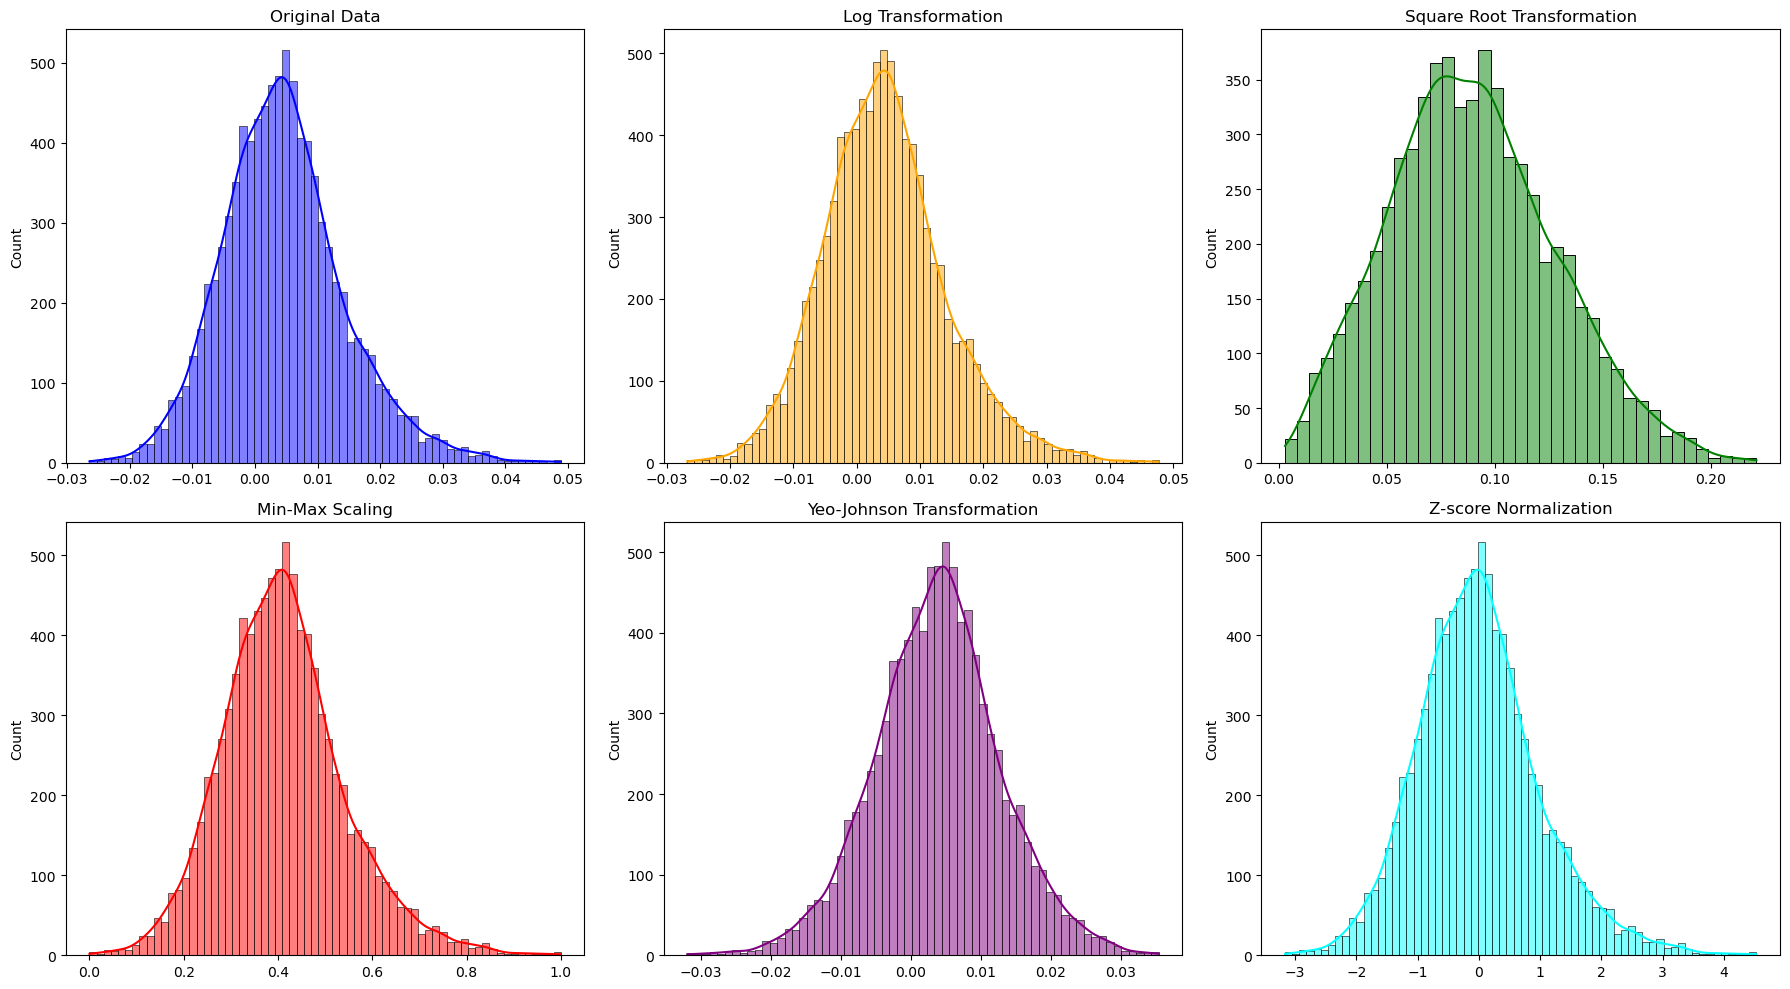

In [63]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming `data` is your 1D numpy array containing the numeric data you want to visualize
data = stacked_data[:,1]

# Transformations
data_log = np.log1p(data)  # Log transformation
data_sqrt = np.sqrt(data)  # Square root transformation
#data_boxcox, _ = stats.boxcox(data + 1e-10)  # Box-Cox transformation; adding a small value to avoid log(0)
data_yeojohnson, _ = stats.yeojohnson(data)  # Yeo-Johnson transformation


data_minmax = (data - np.min(data)) / (np.max(data) - np.min(data))  # Min-Max scaling
data_zscore = (data - np.mean(data)) / np.std(data)  # Z-score normalization

# Visualization
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Original data
sns.histplot(data, kde=True, ax=axs[0, 0], color='blue')
axs[0, 0].set_title('Original Data')

# Log transformation
sns.histplot(data_log, kde=True, ax=axs[0, 1], color='orange')
axs[0, 1].set_title('Log Transformation')

# Square root transformation
sns.histplot(data_sqrt, kde=True, ax=axs[0, 2], color='green')
axs[0, 2].set_title('Square Root Transformation')


# Min-Max scaling
sns.histplot(data_minmax, kde=True, ax=axs[1, 0], color='red')
axs[1, 0].set_title('Min-Max Scaling')

# Box-Cox transformation
#sns.histplot(data_boxcox, kde=True, ax=axs[1, 0], color='red')
#axs[1, 0].set_title('Box-Cox Transformation')

# Yeo-Johnson transformation
sns.histplot(data_yeojohnson, kde=True, ax=axs[1, 1], color='purple')
axs[1, 1].set_title('Yeo-Johnson Transformation')

# Z-score normalization
sns.histplot(data_zscore, kde=True, ax=axs[1, 2], color='cyan')
axs[1, 2].set_title('Z-score Normalization')

plt.tight_layout()
plt.show()

In [64]:
np.mean(data)

0.004544321005125835

In [65]:
np.std(data)  # Z-score normalization

0.009782773269148433

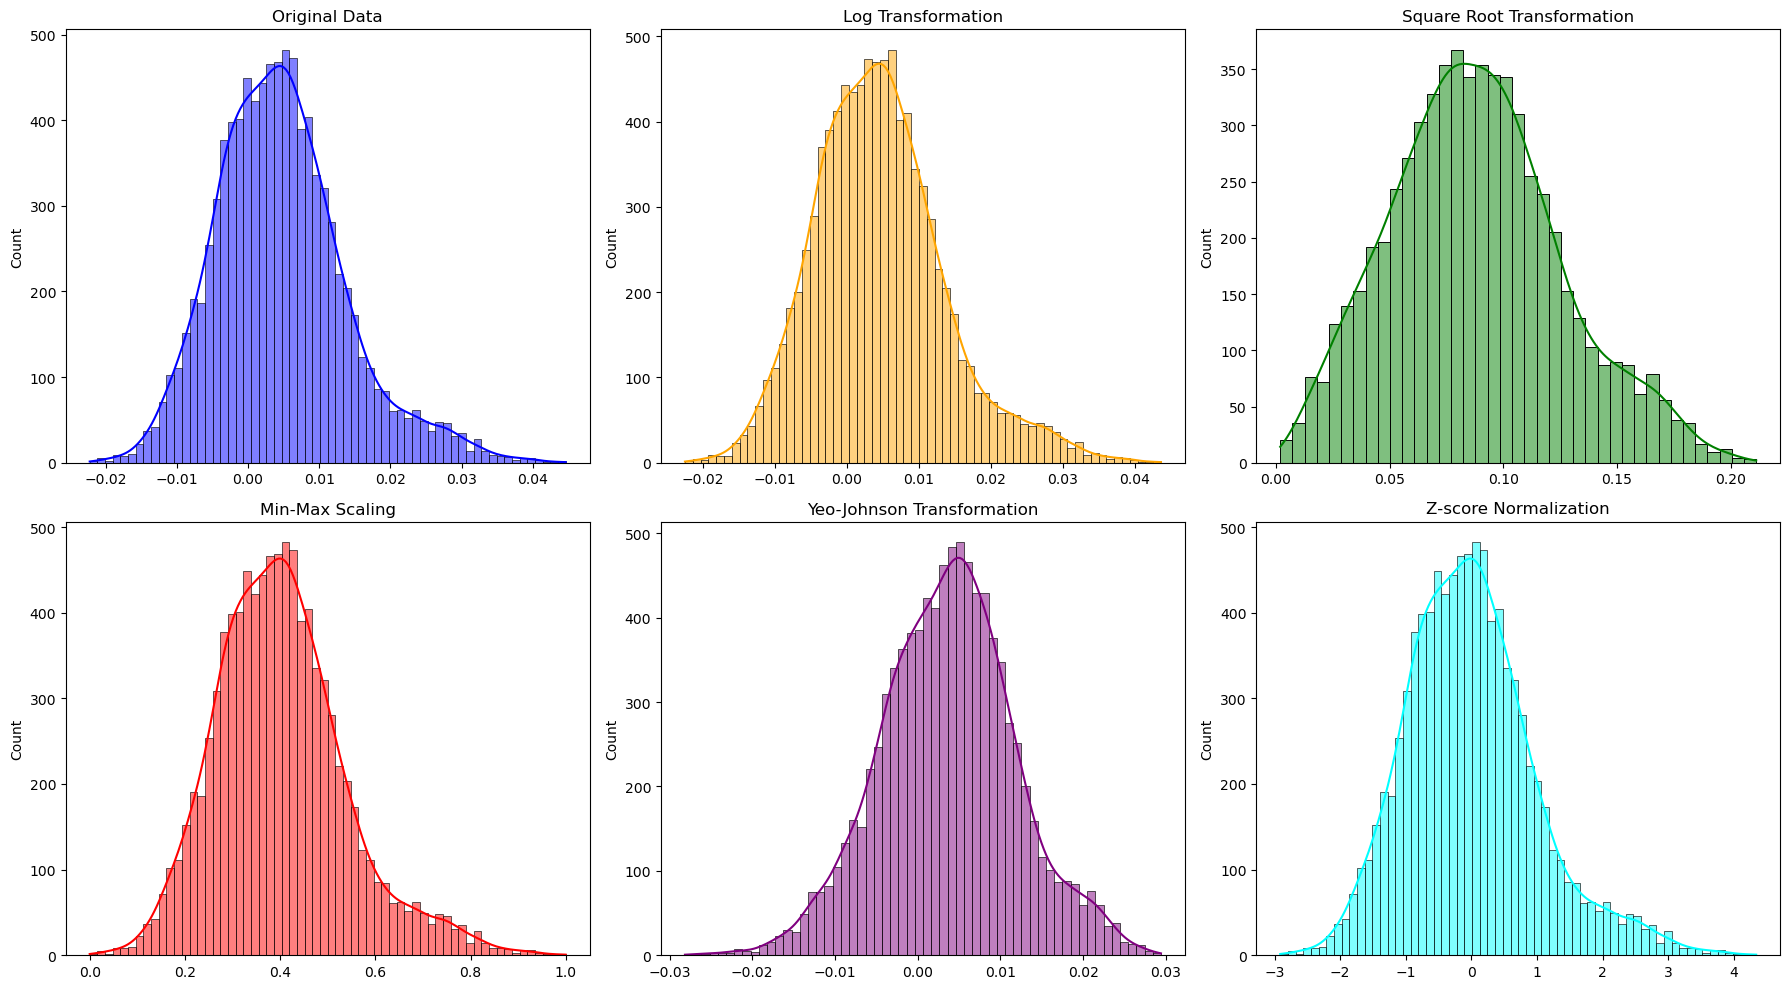

In [66]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming `data` is your 1D numpy array containing the numeric data you want to visualize
data = stacked_data[:,250]

# Transformations
data_log = np.log1p(data)  # Log transformation
data_sqrt = np.sqrt(data)  # Square root transformation
#data_boxcox, _ = stats.boxcox(data + 1e-10)  # Box-Cox transformation; adding a small value to avoid log(0)
data_yeojohnson, _ = stats.yeojohnson(data)  # Yeo-Johnson transformation


data_minmax = (data - np.min(data)) / (np.max(data) - np.min(data))  # Min-Max scaling
data_zscore = (data - np.mean(data)) / np.std(data)  # Z-score normalization

# Visualization
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Original data
sns.histplot(data, kde=True, ax=axs[0, 0], color='blue')
axs[0, 0].set_title('Original Data')

# Log transformation
sns.histplot(data_log, kde=True, ax=axs[0, 1], color='orange')
axs[0, 1].set_title('Log Transformation')

# Square root transformation
sns.histplot(data_sqrt, kde=True, ax=axs[0, 2], color='green')
axs[0, 2].set_title('Square Root Transformation')


# Min-Max scaling
sns.histplot(data_minmax, kde=True, ax=axs[1, 0], color='red')
axs[1, 0].set_title('Min-Max Scaling')

# Box-Cox transformation
#sns.histplot(data_boxcox, kde=True, ax=axs[1, 0], color='red')
#axs[1, 0].set_title('Box-Cox Transformation')

# Yeo-Johnson transformation
sns.histplot(data_yeojohnson, kde=True, ax=axs[1, 1], color='purple')
axs[1, 1].set_title('Yeo-Johnson Transformation')

# Z-score normalization
sns.histplot(data_zscore, kde=True, ax=axs[1, 2], color='cyan')
axs[1, 2].set_title('Z-score Normalization')

plt.tight_layout()
plt.show()

In [68]:
if(not 100 % 10):
    print('m')

m


: 